# **Pipelines**

## 1. Создание Pipeline с использованием стандартных функций 

#### Демонстрацию работы с конвеерами данных Pipeline будем демонстрировать на классификации набора данных "fetch_20newsgroups", содержащий новостные документы, разделённые по группам.  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html

In [15]:
#подключаем необходимые библиотеки
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

#### Выгружаем данные, при этом перемешивая и удаляя разметочную информацию

In [16]:
data_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=228, remove=('headers', 'footers', 'quotes'))
data_test = fetch_20newsgroups(subset='test', shuffle=True, random_state=228, remove=('headers', 'footers', 'quotes'))

In [17]:
data_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [18]:
# Определяем первый наш конвеер, с использованием векторизатора
preprocessor = Pipeline(steps=[('embeddings', TfidfVectorizer())])

#### Обучаем логистическую регрессию с использованием простого Pipeline

In [19]:
pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
pipeline.fit(data_train.data, data_train.target)
pipeline.score(data_test.data, data_test.target)

0.6736590546999469

#### Результат классификации - **0.67**, запомним его для финального сравнения с более сложными конвеерами

## 2. Применение функции make_pipeline с нормализатором данных

#### Примененим к данным функции нормализации, а также уменьшение размерности, для того чтобы ускорить процесс обучения логистической регрессии.

In [20]:
data_train = fetch_20newsgroups(subset='train', 
                                shuffle=True, random_state=228,
                                remove=('headers', 'footers', 'quotes'))
n_components = 2
vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words='english', use_idf=True)
X_train = vectorizer.fit_transform(data_train.data)

svd = TruncatedSVD(n_components)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_train = lsa.fit_transform(X_train)

In [21]:
data_test = fetch_20newsgroups(subset='test', 
                               shuffle=True, random_state=228,
                               remove=('headers', 'footers', 'quotes'))

target_names = data_train.target_names

y_train, y_test = data_train.target, data_test.target
X_test = vectorizer.transform(data_test.data)
X_test = lsa.fit_transform(X_test)

In [22]:
# Обучим также логистическую регрессию
lr_clf = LogisticRegression(max_iter=10000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [23]:
lr_pred = lr_clf.predict(X_train)
train_score = accuracy_score(y_train, lr_pred) * 100
print(f"Оценка по тренировочным данным: {train_score:.2f}%")

lr_pred = lr_clf.predict(X_test)
test_score = accuracy_score(y_test, lr_pred) * 100
print(f"Оценка по тестовым данным: {test_score:.2f}%")

Оценка по тренировочным данным: 15.75%
Оценка по тестовым данным: 14.74%


#### Как можно заметить результат стал хуже, потому что на него сильно влияет размерность выборки, посмотрим на результат без его применения

In [24]:
X_train = vectorizer.fit_transform(data_train.data)
lsa = make_pipeline(normalizer)
X_train = lsa.fit_transform(X_train)
X_test = vectorizer.transform(data_test.data)
X_test = lsa.fit_transform(X_test)

lr_clf = LogisticRegression(max_iter=10000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_train)

train_score = accuracy_score(y_train, lr_pred) * 100
print(f"Оценка по тренировочным данным: {train_score:.2f}%")

lr_pred = lr_clf.predict(X_test)
test_score = accuracy_score(y_test, lr_pred) * 100
print(f"Оценка по тестовым данным: {test_score:.2f}%")

Оценка по тренировочным данным: 91.44%
Оценка по тестовым данным: 68.92%


#### Точность значительно выросла, и немного выросла по сравнению с первой классификацией.

#### Рассмотрим точность по всем группам

In [25]:
pd.DataFrame(classification_report(y_test, lr_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.491582,0.457680,0.474026,319.000000
1,0.634483,0.709512,0.669903,389.000000
2,0.654255,0.624365,0.638961,394.000000
3,0.680217,0.640306,0.659658,392.000000
4,0.751412,0.690909,0.719892,385.000000
5,0.829912,0.716456,0.769022,395.000000
6,0.758621,0.789744,0.773869,390.000000
7,0.736842,0.707071,0.721649,396.000000
8,0.489297,0.804020,0.608365,398.000000
9,0.805000,0.811083,0.808030,397.000000


#### Построим матрицу корреляции для визуализации полученных данных

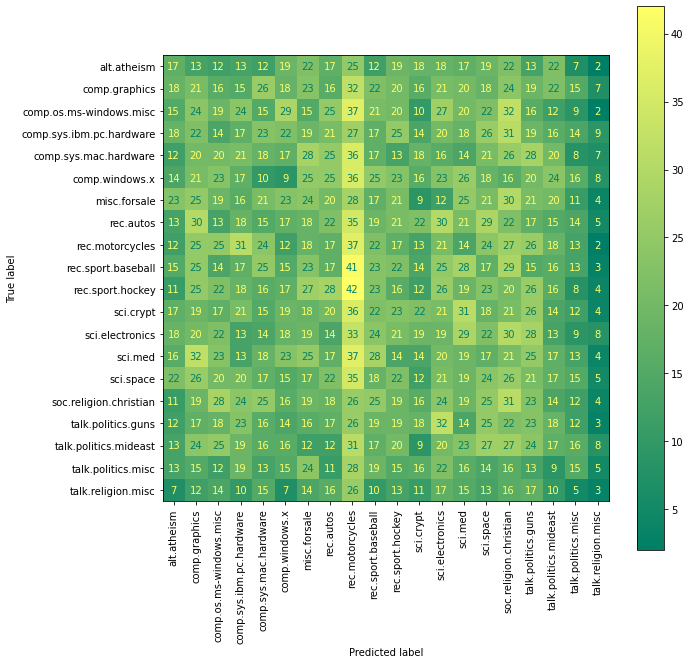

In [42]:
%matplotlib inline

import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, lr_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=data_train.target_names)


fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax, cmap='summer')

plt.show()

## 3. Продвинутые контейнеры данных с применением NLTK

In [27]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

X_train = np.array(newsgroups_train.data)
y_train = np.array(newsgroups_train.target)
X_test = np.array(newsgroups_test.data)
y_test = np.array(newsgroups_test.target)

#### Рассмотрим разделение количество новостных документов по всем анализируемым группам

In [28]:
def conta_labels(y_train, y_test):
    y_train_classes = pd.DataFrame([newsgroups_train.target_names[i] for i in newsgroups_train.target])[0]
    y_test_classes = pd.DataFrame([newsgroups_test.target_names[i] for i in newsgroups_test.target])[0]
    
    contagem_df = pd.concat([y_train_classes.value_counts(),
                             y_test_classes.value_counts()],
                            axis=1, 
                            keys=["Тренировочные", "Тестовые"], 
                            sort=False)
    
    contagem_df["Общие"] = contagem_df.sum(axis=1)
    contagem_df.loc["Сумма"] = contagem_df.sum(axis=0)
    
    return contagem_df

newsgroups_df_labels = conta_labels(y_train, y_test)
newsgroups_df_labels

,Тренировочные,Тестовые,Общие
rec.sport.hockey,600,399,999
soc.religion.christian,599,398,997
rec.motorcycles,598,398,996
rec.sport.baseball,597,397,994
sci.crypt,595,396,991
rec.autos,594,396,990
sci.med,594,396,990
comp.windows.x,593,395,988
sci.space,593,394,987
comp.os.ms-windows.misc,591,394,985


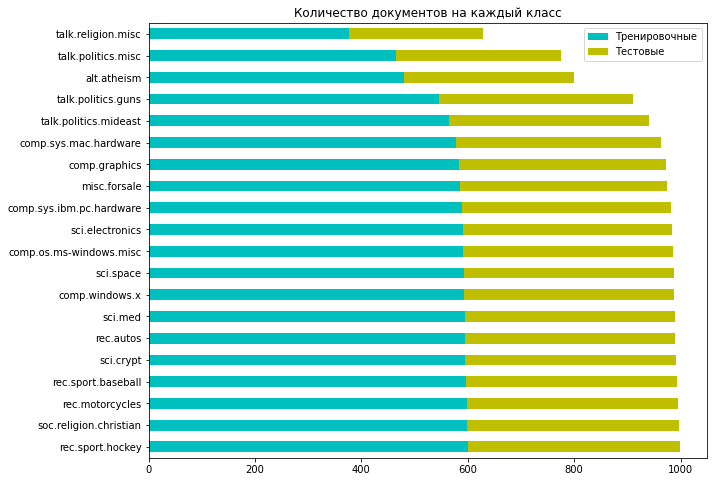

In [43]:
newsgroups_df_labels.iloc[:-1,:-1].plot.barh(stacked=True, 
                                    figsize=(10, 8),
                                    color = 'cym',
                                    title="Количество документов на каждый класс");

#### Используем модуль для обработки языка - NLTK. И создадим класс, который получает на вход новостной документ, а возравращает наборы слов с удалёнными стоп-словами и пунктуационными знаками.

In [30]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics

In [31]:
import string
import re
import nltk

class NLTKTokenizer(): 
    def __init__(self):
        self.lemmatizer = nltk.stem.WordNetLemmatizer()
        self.stopwords = nltk.corpus.stopwords.words('english')
        self.english_words = set(nltk.corpus.words.words())
        self.pontuacao = string.punctuation

    def __call__(self, doc):
        doc = doc.lower()       
        doc = re.sub(r'[0-9]+', 'num', doc)
        doc = re.sub(r'[_]+', 'underline', doc)
        doc = re.sub(r'(http|https)://[^\s]*', 'http', doc)
        doc = re.sub(r'[^\s]+@[^\s]+', 'email', doc) 
        doc = re.sub(r'\\r\\n', ' ', doc)
        doc = re.sub(r'\W', ' ', doc)
        doc = re.sub(r'\s+[a-zA-Z]\s+', ' ', doc)
        doc = re.sub(r'\^[a-zA-Z]\s+', ' ', doc) 
        doc = re.sub(r'\s+', ' ', doc, flags=re.I)
        palavras = []
        for word in nltk.word_tokenize(doc):
            if word in self.stopwords:
                continue
            if word in self.pontuacao:
                continue
            if word not in self.english_words:
                continue
            
            word = self.lemmatizer.lemmatize(word)
            palavras.append(word)
        
        return palavras

#### Преобразуем данные в векторные признаки с помощью библиотек NLTK и регулярных выражений.


In [32]:
vectorizator = CountVectorizer()
v1 = vectorizator.fit_transform(X_train)

features = vectorizator.get_feature_names()
v1_df = pd.DataFrame(v1.toarray(), columns = features)
v1_df

,00,000,0000,00000,000000,00000000,0000000004,00000000b,00000001,00000001b,...,zznkzz,zznp,zzrk,zzy_3w,zzz,zzzoh,zzzzzz,zzzzzzt,³ation,ýé
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11309,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11311,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Добавляем название признакам и используем наш токенизатор. (Лемматизация, удаление стоп-слов и неизвестных слов)

In [33]:
nltk_vectorizator = CountVectorizer(tokenizer=NLTKTokenizer())
v2 = nltk_vectorizator.fit_transform(X_train)

features = nltk_vectorizator.get_feature_names()
v2_df = pd.DataFrame(v2.toarray(), columns = features)
v2_df

,aa,aam,aba,abandon,abandoned,abatement,abbey,abbot,abbreviation,abdication,...,zombie,zonal,zone,zoning,zoo,zooid,zoological,zoology,zoom,zorro
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11309,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11311,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Логистическая регрессия: с применением конвейера данных (TfidfVectorizer, TfidfTransformer, LogisticRegression)

In [34]:
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

text_clf_logistic_regression = Pipeline([('vect', TfidfVectorizer(max_df=0.5, min_df=2, 
                                                              stop_words='english', 
                                                              use_idf=True)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(penalty='l2', 
                                                dual=False, 
                                                tol=0.001, 
                                                C=1.0, 
                                                fit_intercept=True, 
                                                intercept_scaling=1, 
                                                class_weight=None, 
                                                random_state=None, 
                                                solver='lbfgs', 
                                                max_iter=1000, 
                                                multi_class='multinomial', 
                                                verbose=0, 
                                                warm_start=False, 
                                                n_jobs=None, 
                                                l1_ratio=None)),
                     ])

text_clf_logistic_regression.fit(X_train, y_train)
predicted = text_clf_logistic_regression.predict(X_test)
lr_tf_score = accuracy_score(y_test, predicted)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.55      0.45      0.49       319
           1       0.65      0.75      0.69       389
           2       0.67      0.65      0.66       394
           3       0.68      0.66      0.67       392
           4       0.78      0.70      0.74       385
           5       0.87      0.73      0.79       395
           6       0.75      0.78      0.76       390
           7       0.75      0.74      0.74       396
           8       0.50      0.82      0.62       398
           9       0.85      0.83      0.84       397
          10       0.91      0.89      0.90       399
          11       0.91      0.71      0.80       396
          12       0.59      0.62      0.60       393
          13       0.79      0.81      0.80       396
          14       0.72      0.79      0.76       394
          15       0.63      0.82      0.71       398
          16       0.61      0.70      0.65       364
          17       0.88    

#### Логистическая регрессия: с применением конвейера данных (NLTKTokenizer, TfidfTransformer, LogisticRegression)

In [35]:
text_clf_logistic_regression = Pipeline([('vect', CountVectorizer(tokenizer=NLTKTokenizer())),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(penalty='l2', 
                                                dual=False, 
                                                tol=0.001, 
                                                C=1.0, 
                                                fit_intercept=True, 
                                                intercept_scaling=1, 
                                                class_weight=None, 
                                                random_state=None, 
                                                solver='lbfgs', 
                                                max_iter=1000, 
                                                multi_class='multinomial', 
                                                verbose=0, 
                                                warm_start=False, 
                                                n_jobs=None, 
                                                l1_ratio=None)),
                     ])

text_clf_logistic_regression.fit(X_train, y_train)
predicted = text_clf_logistic_regression.predict(X_test)
lr_nltk_score = accuracy_score(y_test, predicted)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.42      0.38      0.40       319
           1       0.56      0.59      0.58       389
           2       0.47      0.47      0.47       394
           3       0.57      0.50      0.53       392
           4       0.66      0.55      0.60       385
           5       0.70      0.63      0.66       395
           6       0.72      0.75      0.73       390
           7       0.67      0.65      0.66       396
           8       0.41      0.69      0.52       398
           9       0.67      0.68      0.67       397
          10       0.77      0.76      0.76       399
          11       0.79      0.59      0.68       396
          12       0.48      0.55      0.51       393
          13       0.72      0.75      0.74       396
          14       0.70      0.69      0.70       394
          15       0.57      0.72      0.64       398
          16       0.52      0.57      0.55       364
          17       0.58    

#### Классификация ближайших соседей

In [36]:
from sklearn.neighbors import KNeighborsClassifier

text_clf_knn = Pipeline([('vect', TfidfVectorizer(max_df=0.5, min_df=2, 
                                                              stop_words='english', 
                                                              use_idf=True)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier(n_neighbors=5, 
                                                  weights='uniform', 
                                                  algorithm='auto', 
                                                  leaf_size=30, 
                                                  p=2, 
                                                  metric='minkowski', 
                                                  metric_params=None, 
                                                  n_jobs=None)),
                     ])

text_clf_knn.fit(X_train, y_train)
predicted = text_clf_knn.predict(X_test)
knn_tf_score = accuracy_score(y_test, predicted)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.05      0.15      0.08       319
           1       0.08      0.21      0.12       389
           2       0.06      0.18      0.09       394
           3       0.07      0.09      0.08       392
           4       0.06      0.11      0.08       385
           5       0.18      0.03      0.05       395
           6       0.10      0.11      0.11       390
           7       0.05      0.09      0.06       396
           8       0.12      0.07      0.09       398
           9       0.07      0.08      0.07       397
          10       0.16      0.07      0.09       399
          11       0.16      0.06      0.08       396
          12       0.11      0.04      0.06       393
          13       0.07      0.03      0.04       396
          14       0.20      0.06      0.09       394
          15       0.06      0.01      0.01       398
          16       0.14      0.04      0.06       364
          17       0.16    

In [37]:
text_clf_knn = Pipeline([('vect', CountVectorizer(tokenizer=NLTKTokenizer())),
                     ('tfidf', TfidfTransformer()),
                     ('clf', KNeighborsClassifier(n_neighbors=5, 
                                                  weights='uniform', 
                                                  algorithm='auto', 
                                                  leaf_size=30, 
                                                  p=2, 
                                                  metric='minkowski', 
                                                  metric_params=None, 
                                                  n_jobs=None)),
                     ])

text_clf_knn.fit(X_train, y_train)
predicted = text_clf_knn.predict(X_test)
knn_nltk_score = accuracy_score(y_test, predicted)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.06      0.15      0.08       319
           1       0.08      0.19      0.11       389
           2       0.06      0.19      0.10       394
           3       0.11      0.12      0.11       392
           4       0.08      0.13      0.10       385
           5       0.31      0.08      0.13       395
           6       0.14      0.11      0.12       390
           7       0.05      0.10      0.07       396
           8       0.11      0.08      0.09       398
           9       0.07      0.09      0.08       397
          10       0.17      0.08      0.11       399
          11       0.15      0.04      0.07       396
          12       0.07      0.02      0.03       393
          13       0.07      0.07      0.07       396
          14       0.15      0.04      0.07       394
          15       0.09      0.01      0.02       398
          16       0.06      0.02      0.03       364
          17       0.17    

#### Классификация случайного леса

In [38]:
text_clf_rf = Pipeline([('vect', TfidfVectorizer(max_df=0.5, min_df=2, 
                                                              stop_words='english', 
                                                              use_idf=True)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_estimators=100, 
                                                    criterion='gini', 
                                                    max_depth=None, 
                                                    min_samples_split=2, 
                                                    min_samples_leaf=1, 
                                                    min_weight_fraction_leaf=0.0, 
                                                    max_features='auto', 
                                                    max_leaf_nodes=None, 
                                                    min_impurity_decrease=0.0, 
                                                    bootstrap=True, 
                                                    oob_score=False, 
                                                    n_jobs=None, 
                                                    random_state=None, 
                                                    verbose=0, 
                                                    warm_start=False))])

text_clf_rf.fit(X_train, y_train)
predicted = text_clf_rf.predict(X_test)
rfc_tf_score = accuracy_score(y_test, predicted)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.45      0.38      0.41       319
           1       0.58      0.58      0.58       389
           2       0.57      0.65      0.61       394
           3       0.61      0.57      0.59       392
           4       0.64      0.66      0.65       385
           5       0.65      0.68      0.67       395
           6       0.71      0.74      0.72       390
           7       0.42      0.71      0.53       396
           8       0.68      0.68      0.68       398
           9       0.69      0.77      0.73       397
          10       0.80      0.81      0.80       399
          11       0.77      0.64      0.70       396
          12       0.51      0.44      0.47       393
          13       0.72      0.64      0.68       396
          14       0.66      0.66      0.66       394
          15       0.57      0.78      0.66       398
          16       0.51      0.56      0.53       364
          17       0.84    

In [39]:
text_clf_rf = Pipeline([('vect', TfidfVectorizer(max_df=0.5, min_df=2, 
                                                              stop_words='english', 
                                                              use_idf=True)),
                     ('tfidf', TfidfTransformer()),
                     ('clf', RandomForestClassifier(n_estimators=100, 
                                                    criterion='gini', 
                                                    max_depth=None, 
                                                    min_samples_split=2, 
                                                    min_samples_leaf=1, 
                                                    min_weight_fraction_leaf=0.0, 
                                                    max_features='auto', 
                                                    max_leaf_nodes=None, 
                                                    min_impurity_decrease=0.0, 
                                                    bootstrap=True, 
                                                    oob_score=False, 
                                                    n_jobs=None, 
                                                    random_state=None, 
                                                    verbose=0, 
                                                    warm_start=False))])

text_clf_rf.fit(X_train, y_train)
predicted = text_clf_rf.predict(X_test)
rfc_nltk_score = accuracy_score(y_test, predicted)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.46      0.38      0.41       319
           1       0.57      0.60      0.59       389
           2       0.55      0.62      0.59       394
           3       0.61      0.56      0.58       392
           4       0.66      0.65      0.66       385
           5       0.64      0.67      0.66       395
           6       0.67      0.74      0.71       390
           7       0.40      0.70      0.51       396
           8       0.68      0.66      0.67       398
           9       0.69      0.79      0.74       397
          10       0.83      0.81      0.82       399
          11       0.76      0.63      0.69       396
          12       0.49      0.43      0.46       393
          13       0.75      0.66      0.70       396
          14       0.66      0.65      0.66       394
          15       0.57      0.79      0.66       398
          16       0.53      0.56      0.55       364
          17       0.84    

#### Анализ полученных результатов

In [40]:
models = [('LogisticRegression_TV', lr_tf_score),
          ('LogisticRegression_NLTK', lr_nltk_score),
          ('KNeighborsClassifier_TV', knn_tf_score),
          ('KNeighborsClassifier_NLTK', knn_nltk_score),
          ('RandomForestClassifier_TV', rfc_tf_score),
          ('RandomForestClassifier_NLTK', rfc_nltk_score)
          ]

In [41]:
total = pd.DataFrame(data=models, columns=['Model', 'Score'])
total = total.sort_values(by=['Score'], ignore_index=True, ascending=False)
total

,Model,Score
0,LogisticRegression_TV,0.707913
1,RandomForestClassifier_TV,0.617897
2,RandomForestClassifier_NLTK,0.616569
3,LogisticRegression_NLTK,0.596920
4,KNeighborsClassifier_NLTK,0.083510
5,KNeighborsClassifier_TV,0.077005


#### Наилучший классификатор оказался - Логистическая регрессия, где мы снова смогли улучшить результат.

#### В каждом из классификаторов мы применяли 2 типа векторизаторов - собранный нами выше с примением модуля NLTK и TfidfTransformer, с немного изменными параметрами. Pipeline дают нам возможности удобно работать с данными и применять к ним одновременно несколько необходимых инструментов. Это позволяет нам последовательно обработать данные, без их утечки или потери.

#### Подводя итоги анализа данных с применением контейнера данных Pipeline:
+ Наилучший результат показала модель Логистической регрессии с TF-IDF векторизатором.
+ Векторизатор на основе предобработки данных NLTK показал результат хуже, только на одной модели он достиг лучшей точности - KNeighborsClassifier.
+ Применение классификации ближайших соседий было бесполезно, что и стоило доказать, так как наши данные находятся в перемешанном варианте.
